In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# Parameters for trust region
tol = 1e-6 # stop iterations when ||grad f|| < tol
iter_max = 200 # the maximal number of iterations
Delta_max = 5 # the max trust-region radius
Delta_min = 1e-12 # the minimal trust-region radius
Delta = 1 # the initial trust region radius
eta = 0.1 # step rejection parameter
subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
tol_sub = 1e-1 # relative tolerance for the subproblem
rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius

def cauchy_point(B, g, Delta):
    ng = np.linalg.norm(g)
    ps = -g * Delta / ng
    aux = np.dot(g, B @ g)
    if aux <= 0:
        p = ps
    else:
        a = np.minimum(ng**3 / (Delta * aux), 1)
        p = ps * a
    return p

In [3]:
# Set up the initial configuration

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.

Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
model = 0

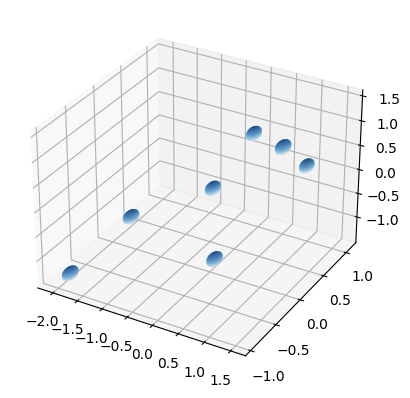

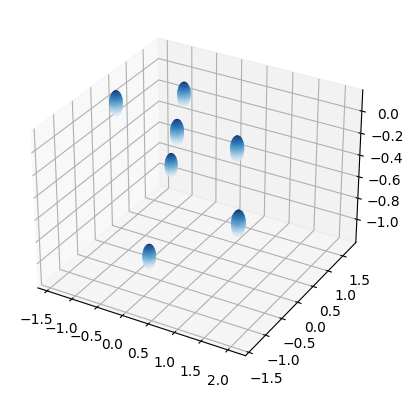

LJpot =  -6.237150592144485


In [4]:
# select the initial configuration
xyz = initial_configuration(model, Na, rstar)
drawconf(xyz, 0.5 * rstar)

x = remove_rotations_translations(xyz)
drawconf(LJvector2array(x), 0.5 * rstar)
print(f'LJpot =  {LJpot(x)}')

In [5]:
# initialization
f = LJpot(x)
g = LJgrad(x)
norm_g = np.linalg.norm(g)
print(f'Initially, f = {f}, ||grad f|| = {norm_g}')

fvals = [f]
ngvals = [norm_g]

I = np.eye(np.size(x), dtype=float)

Initially, f = -6.237150592144485, ||grad f|| = 6.597178821551943


Reject: iter 1: f = -6.2371505921, |df| = 6.5972e+00, rho = -7.1876e+02, Delta = 2.5000e-01, j_sub = 2
Accept: iter 2: f = -7.4468195296, |df| = 6.7850e+00, rho = 8.3974e-01, Delta = 5.0000e-01, j_sub = 3
Reject: iter 3: f = -7.4468195296, |df| = 6.7850e+00, rho = -5.3045e+01, Delta = 1.2500e-01, j_sub = 2
Accept: iter 4: f = -8.0613423322, |df| = 4.5290e+00, rho = 9.5916e-01, Delta = 2.5000e-01, j_sub = 3
Accept: iter 5: f = -8.6127721403, |df| = 1.3286e+01, rho = 5.5452e-01, Delta = 2.5000e-01, j_sub = 3
Accept: iter 6: f = -9.6446951778, |df| = 3.2608e+00, rho = 8.4082e-01, Delta = 5.0000e-01, j_sub = 3
Accept: iter 7: f = -10.5651820061, |df| = 7.8768e+00, rho = 7.7673e-01, Delta = 1.0000e+00, j_sub = 2
Reject: iter 8: f = -10.5651820061, |df| = 7.8768e+00, rho = -1.6325e+02, Delta = 2.5000e-01, j_sub = 1
Reject: iter 9: f = -10.5651820061, |df| = 7.8768e+00, rho = -1.4361e+00, Delta = 6.2500e-02, j_sub = 3
Accept: iter 10: f = -10.9676663574, |df| = 4.0799e+00, rho = 9.1525e-01, D

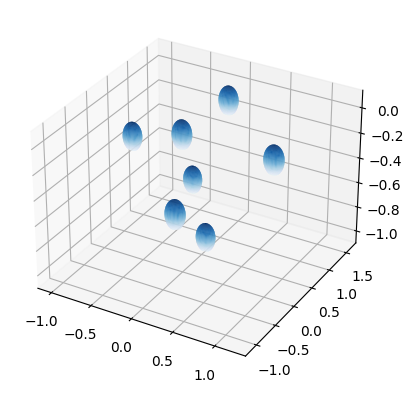

Accept: iter 20: f = -12.8666288258, |df| = 7.5547e+00, rho = 2.5460e-01, Delta = 2.5000e-01, j_sub = 3
Accept: iter 21: f = -13.2980553488, |df| = 2.2259e+00, rho = 7.7400e-01, Delta = 5.0000e-01, j_sub = 2
Accept: iter 22: f = -13.8108487472, |df| = 1.5811e+01, rho = 4.0811e-01, Delta = 5.0000e-01, j_sub = 2
Reject: iter 23: f = -13.8108487472, |df| = 1.5811e+01, rho = -1.0666e-01, Delta = 1.2500e-01, j_sub = 4
Accept: iter 24: f = -14.3412371640, |df| = 4.4759e+00, rho = 9.6126e-01, Delta = 2.5000e-01, j_sub = 3
Accept: iter 25: f = -14.7268916619, |df| = 1.9131e+00, rho = 8.9750e-01, Delta = 5.0000e-01, j_sub = 2
Accept: iter 26: f = -15.2577019226, |df| = 5.2607e+00, rho = 7.1303e-01, Delta = 5.0000e-01, j_sub = 2
Accept: iter 27: f = -15.2903062436, |df| = 1.0137e+01, rho = 1.0646e-01, Delta = 1.2500e-01, j_sub = 0
Accept: iter 28: f = -15.5059232855, |df| = 2.6767e+00, rho = 1.1317e+00, Delta = 1.2500e-01, j_sub = 0
Accept: iter 29: f = -15.5322176066, |df| = 3.9317e-01, rho = 1

In [6]:
# the main trust-region cycle
iter = 1
while (norm_g > tol and iter < iter_max):
    # solve the constrained minimization problem
    B = LJhess(x)
    flag_boundary = 0
    # check if B is SPD
    eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
    j_sub = 0
    if eval_min > 0: # B is SPD: B = R' * R, R' * R * p = -g
        p = scipy.linalg.solve(B, -g)
        p_norm = np.linalg.norm(p)
        if p_norm > Delta: # else: we are done with solving the subproblem
            flag_boundary = 1
    else:
        flag_boundary = 1
    if flag_boundary == 1: # solution lies on the boundary
        lam_min = np.maximum(-eval_min, 0.0)
        lam = lam_min + 1
        R = scipy.linalg.cholesky(B + lam * I, lower=False)
        flag_subproblem_success = 0
        while j_sub < subproblem_iter_max:
            j_sub = j_sub + 1
            p = scipy.linalg.solve_triangular(np.transpose(R), -g, lower=True)
            p = scipy.linalg.solve_triangular(R, p, lower=False)
            p_norm = np.linalg.norm(p)
            dd = np.absolute(p_norm - Delta)
            if dd < tol_sub * Delta:
                flag_subproblem_success = 1
                break
            q = scipy.linalg.solve_triangular(np.transpose(R), p, lower=True)
            q_norm = np.linalg.norm(q)
            dlam = (p_norm / q_norm)**2 * (p_norm - Delta) / Delta
            lam_new = lam + dlam
            if lam_new > lam_min:
                lam = lam_new
            else:
                lam = 0.5 * (lam + lam_min)
            R = scipy.linalg.cholesky(B + lam * I, lower=False)
        if( flag_subproblem_success == 0 ):
            p = cauchy_point(B, g, Delta)
    # assess the progress
    xnew = x + p
    fnew = LJpot(xnew)
    gnew = LJgrad(xnew)
    mnew = f + np.dot(g, p) + 0.5 * np.dot(p, B @ p)
    rho = (f - fnew) / (f - mnew + 1e-14)
    # adjust the trust region
    if rho < rho_bad:
        Delta = np.maximum(0.25 * Delta, Delta_min)
    else:
        if rho > rho_good and flag_boundary == 1:
            Delta = np.minimum(Delta_max, 2 * Delta)
    # accept or reject step
    if rho > eta: # accept step
        x = xnew
        f = fnew
        g = gnew
        norm_g = np.linalg.norm(g)
        print(f'Accept: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
    else:
        print(f'Reject: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
    if iter % 20 == 19:
        # restore all coordinates
        xyz = LJvector2array(x)
        drawconf(xyz, 0.5 * rstar)
    fvals.append(f)
    ngvals.append(norm_g)
    iter += 1

### 3. Minimizing Lennard-Jones Pair Potentials via Trust Region

In [7]:
# Four local minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid
# f2 = -15.93504306 Capped octahedron
# f3 = -15.59321094 Tricapped tetrahedron
# f4 = -15.53306005 Bicapped trigonal bipyramid

Text(0, 0.5, '$f_k$')

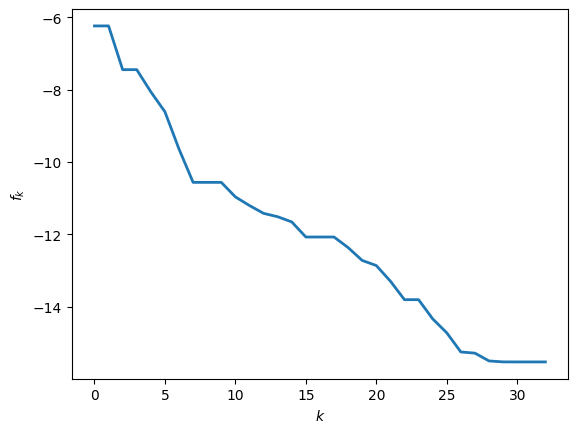

In [8]:
plt.plot(range(len(fvals)), fvals, linewidth=2)
plt.xlabel('$k$')
plt.ylabel('$f_k$')

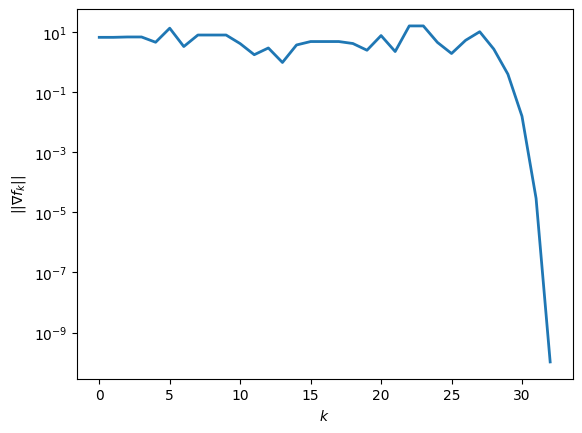

In [9]:
plt.plot(range(len(ngvals)), ngvals, linewidth=2)
plt.xlabel('$k$')
plt.ylabel('$||\\nabla f_k||$')
plt.yscale('log')

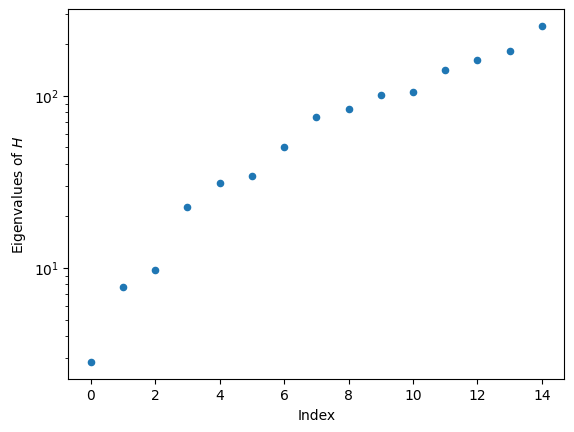

In [10]:
H = LJhess(x)
evals = np.sort(np.linalg.eigvals(H))
plt.scatter(range(len(evals)), evals, s=20)
plt.xlabel('Index')
plt.ylabel('Eigenvalues of $H$')
if evals[0] > 0:
    plt.yscale('log')

### 4. Minimizing Rosenbrock Function via Trust Region